In [1]:
from pathlib import Path

import torch
import torchinfo
import torchtext.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.schemas import NlpContext
from torchlake.sequence_data.models import LstmClassifier
from torchtext.datasets import CoNLL2000Chunking
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm

# setting


In [2]:
data_path = Path("../../data/CoNLL2000")
artifacts_path = Path("../../artifacts/bilstm")

In [3]:
batch_size = 128
context = NlpContext()

# data


In [4]:
def datapipe_factory(datapipe, text_transform=None, label_transform=None):
    datapipe = datapipe.map(
        lambda item: [[word.lower() for word in item[0]], item[1]]
    ).filter(lambda item: len(item[0]) > context.min_seq_len)

    if text_transform:
        datapipe = datapipe.map(lambda item: (text_transform(item[0]), item[1]))

    if label_transform:
        datapipe = datapipe.map(lambda item: (item[0], label_transform(item[1])))

    return datapipe

In [5]:
train_data, test_data = CoNLL2000Chunking(data_path.as_posix())

In [6]:
vocab = build_vocab_from_iterator(
    map(lambda it: it[0], train_data),
    specials=context.special_tokens,
    min_freq=context.min_frequency,
)

vocab.set_default_index(context.unk_idx)

In [7]:
label_vocab = build_vocab_from_iterator(
    map(lambda it: it[1], train_data),
    specials=context.special_tokens,
)

label_vocab.set_default_index(context.unk_idx)

In [8]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [9]:
label_transform = T.Sequential(
    T.VocabTransform(label_vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [10]:
def collate_fn(batch: list):
    text_placeholder, label_placeholder = [], []

    for row in batch:
        text, label = row[0], row[1]
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.stack(label_placeholder)

In [11]:
train_iter = DataLoader(
    datapipe_factory(train_data, text_transform, label_transform),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

test_iter = DataLoader(
    datapipe_factory(test_data, text_transform, label_transform),
    batch_size=batch_size,
    collate_fn=collate_fn,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [12]:
for text, label in train_iter:
    print(text.shape, label.shape)
    break

torch.Size([128, 256]) torch.Size([128, 256])


# model


In [13]:
vocab_size = len(vocab)
label_size = len(label_vocab)

In [14]:
device = torch.device(context.device)

In [15]:
model = LstmClassifier(
    vocab_size,
    128,
    128,
    label_size,
    bidirectional=True,
    context=context,
).to(device)

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
LstmClassifier                           --
├─Embedding: 1-1                         563,968
├─LSTM: 1-2                              264,192
├─LayerNorm: 1-3                         512
├─Linear: 1-4                            12,336
Total params: 841,008
Trainable params: 841,008
Non-trainable params: 0

# train


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [18]:
model.train()
for epoch in range(10):
    running_loss = 0.0

    dataset_count = 0
    for text, label in tqdm(train_iter):
        optimizer.zero_grad()

        text = text.to(device)
        label = label.to(device)

        output = model(text).permute(0, 2, 1)
        loss = criterion(output, label)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        dataset_count += text.size(0)

    print(f"epoch {epoch+1}: {running_loss/dataset_count}")

67it [00:06,  9.80it/s]


epoch 1: 0.027504955376706906


67it [00:04, 15.52it/s]


epoch 2: 0.02085941676884445


67it [00:04, 13.89it/s]


epoch 3: 0.012525479211958486


67it [00:04, 14.24it/s]


epoch 4: 0.0060726042920306545


67it [00:04, 15.21it/s]


epoch 5: 0.003770253933799356


67it [00:04, 15.20it/s]


epoch 6: 0.002976066283464654


67it [00:04, 14.02it/s]


epoch 7: 0.002597235803450666


67it [00:04, 14.58it/s]


epoch 8: 0.0023725111517054376


67it [00:04, 13.76it/s]


epoch 9: 0.002218541908147397


67it [00:05, 12.12it/s]

epoch 10: 0.002105405689703662


# inference


In [19]:
evaluator = ClassificationEvaluator(label_size, device)

In [20]:
with torch.no_grad():
    model.eval()

    confusion_matrix = IncrementalConfusionMatrix(label_size)
    for text, label in tqdm(train_iter):
        text = text.to(device)

        output = model(text).argmax(dim=2)

        confusion_matrix.update(
            label.view(-1).numpy(),
            output.view(-1).detach().cpu().numpy(),
        )

    print(confusion_matrix)

67it [00:05, 12.04it/s]

[[   0    0    0 ...    0    0    0]
 [   0 8576    0 ...    0    0    0]
 [   0    0 8576 ...    0    0    0]
 ...
 [   0    0   19 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]


In [21]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(label_vocab.get_itos(), per_class_acc)

<unk>     : 0.0
<bos>     : 1.0
<eos>     : 1.0
<pad>     : 1.0
NN        : 0.25462136772281896
IN        : 0.7260353187135804
NNP       : 0.8152735834570303
DT        : 0.8586986566421582
NNS       : 0.04979098238280084
JJ        : 0.018291737715082933
,         : 1.0
.         : 0.9877508166122259
CD        : 0.013742331288343559
VBD       : 0.01824212271973466
RB        : 0.0018581604211830288
VB        : 0.013308625336927223
CC        : 0.5993958844629035
TO        : 0.9900279218189071
VBN       : 0.0019177498401875134
VBZ       : 0.050699300699300696
PRP       : 0.0
VBG       : 0.0
VBP       : 0.0010645848119233499
MD        : 0.0
PRP$      : 0.001610305958132045
POS       : 0.047180667433831994
$         : 0.013271783035199077
``        : 0.14890800794176043
''        : 0.18009478672985782
:         : 0.0
WDT       : 0.0
JJR       : 0.0023752969121140144
WP        : 0.0
WRB       : 0.0
NNPS      : 0.0
JJS       : 0.0
RBR       : 0.0
)         : 0.0
(         : 0.0
EX        : 0.0

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:63: RuntimeWarning: invalid value encountered in divide
  return np.where(total == 0, 0, hits / total)


d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:82: RuntimeWarning: invalid value encountered in divide
  percentage = np.where(total == 0, 0, hits / total)


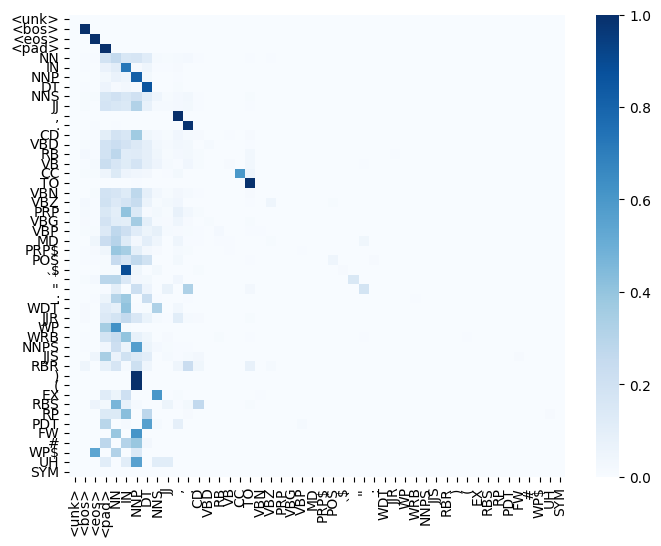

In [24]:
evaluator.plot_confusion_matrix(confusion_matrix, label_vocab.get_itos(), 'Blues', annot=False)

In [17]:
model_path = artifacts_path / 'bilstm.pth'

In [28]:
torch.save(model.state_dict(), model_path.as_posix())

In [18]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>